In [700]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader.av.forex import AVForexReader

n_test=10
n_lags=10
ickers = ['AAPL', 'MSFT', '^GSPC']

from datetime import datetime
# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = datetime.strptime('2017-01-01','%Y-%m-%d')
end_date = datetime.strptime('2020-12-31' ,'%Y-%m-%d')

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
panel_df_1= data.DataReader(["^DJI",'RUB=X'], 'yahoo', start_date, end_date).dropna()
panel_df_2= data.DataReader("EFFR", 'fred', start_date, end_date).dropna()
# df=panel_df_1.join(panel_df_2,how="left",on="date")

df_raw=pd.concat([panel_df_1, panel_df_2], axis=1, join='outer')


In [701]:
df_joined=df_raw.copy()

In [702]:
df_joined['date']=df_joined.index

In [703]:
columns_to_select=df_joined.columns[["Close"==i[0] or i=="EFFR" for i in df_joined.columns]]

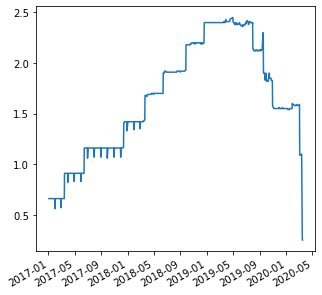

In [704]:
df_joined=df_joined.interpolate()
df_joined['EFFR'].plot(figsize=(5,5))


In [705]:
# df_joined['EFFR'].plot(figsize=(10,10))
# df_joined[columns_to_select].diff()

In [706]:
diff_df=df_joined[columns_to_select].diff().dropna()

In [707]:
diff_df.dropna(inplace=True)
diff_df=diff_df[abs(diff_df.iloc[:,1])<20]
# diff_df=diff_df[diff_df.iloc[:,2]<10]

In [708]:
diff_df['EFFR'][diff_df['EFFR']>0.1 ]=1
diff_df['EFFR'][diff_df['EFFR']<-0.1 ]=-1
diff_df['EFFR'][abs(diff_df['EFFR'])<0.1 ]=0


('Close', 'RUB=X')


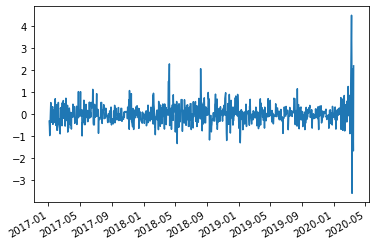

In [709]:
diff_df.iloc[:,1].plot()
print(diff_df.columns[1])

EFFR


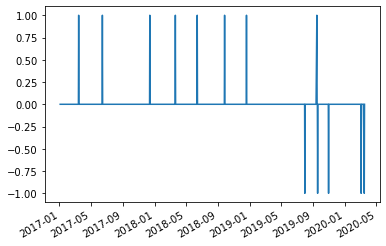

In [710]:
diff_df.iloc[:,2].plot()
print(diff_df.columns[2])

In [711]:
# !pip install statsmodels
from statsmodels.tsa.stattools import grangercausalitytests
# EFFR -> RUB/X
gc_res = grangercausalitytests(diff_df.iloc[:,[1,2]], 10)
# RUB/X -> EFFR
gc_res = grangercausalitytests(diff_df.iloc[:,[2,1]], 10)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7220  , p=0.3957  , df_denom=805, df_num=1
ssr based chi2 test:   chi2=0.7247  , p=0.3946  , df=1
likelihood ratio test: chi2=0.7244  , p=0.3947  , df=1
parameter F test:         F=0.7220  , p=0.3957  , df_denom=805, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8520  , p=0.4269  , df_denom=802, df_num=2
ssr based chi2 test:   chi2=1.7147  , p=0.4243  , df=2
likelihood ratio test: chi2=1.7128  , p=0.4247  , df=2
parameter F test:         F=0.8520  , p=0.4269  , df_denom=802, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0271  , p=0.3799  , df_denom=799, df_num=3
ssr based chi2 test:   chi2=3.1082  , p=0.3752  , df=3
likelihood ratio test: chi2=3.1022  , p=0.3761  , df=3
parameter F test:         F=1.0271  , p=0.3799  , df_denom=799, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9774  , p=0.4190  

In [712]:
# from statsmodels.tsa.api import VAR
# mod = VAR(diff_df)
# res = mod.fit(maxlags=15, ic='aic')
# print(res.summary())

In [713]:
diff_df.head(5)

,"(Close, ^DJI)","(Close, RUB=X)",EFFR
2017-01-04,60.400391,-0.305298,0.0
2017-01-05,-42.871094,-0.557999,0.0
2017-01-06,64.511719,-0.963802,0.0
2017-01-09,-76.419922,0.163799,0.0
2017-01-10,-31.851562,0.537502,0.0


In [714]:
diff_df.iloc[:,1]

2017-01-04   -0.305298
2017-01-05   -0.557999
2017-01-06   -0.963802
2017-01-09    0.163799
2017-01-10    0.537502
                ...   
2020-03-11   -3.590797
2020-03-12    2.064796
2020-03-13    1.783104
2020-03-16   -1.660103
2020-03-17    2.208252
Name: (Close, RUB=X), Length: 809, dtype: float64

In [1]:
# import statsmodels.tsa.stattools as stt
import statsmodels
model=statsmodels.tsa.arima_model.ARIMA(diff_df.iloc[:,1],(10,0,0),diff_df.iloc[:,2])

AttributeError: module 'statsmodels' has no attribute 'tsa'

In [716]:
for i in range(n_test):
    diff_df.loc[len(diff_df)] = 0
    
# diff_df.tail(5)

,"(Close, ^DJI)","(Close, RUB=X)",EFFR
814,0.0,0.0,0.0
815,0.0,0.0,0.0
816,0.0,0.0,0.0
817,0.0,0.0,0.0
818,0.0,0.0,0.0


In [717]:
# model_fit = model.fit(disp=0)

df_res=pd.concat([diff_df.shift(i)['EFFR'] for i in range(1,n_lags)]+[diff_df],axis=1)
df_res.head(4)


,EFFR,EFFR,EFFR,EFFR,EFFR,EFFR,EFFR,EFFR,EFFR,"(Close, ^DJI)","(Close, RUB=X)",EFFR
2017-01-04 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.400391,-0.305298,0.0
2017-01-05 00:00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-42.871094,-0.557999,0.0
2017-01-06 00:00:00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.511719,-0.963802,0.0
2017-01-09 00:00:00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,-76.419922,0.163799,0.0


In [718]:
import statsmodels.api as sm
# df_res = sm.add_constant(df_res, prepend=True)

In [719]:
df_res.fillna(0,inplace=True)
df_res.head(5)


,EFFR,EFFR,EFFR,EFFR,EFFR,EFFR,EFFR,EFFR,EFFR,"(Close, ^DJI)","(Close, RUB=X)",EFFR
2017-01-04 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.400391,-0.305298,0.0
2017-01-05 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-42.871094,-0.557999,0.0
2017-01-06 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.511719,-0.963802,0.0
2017-01-09 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-76.419922,0.163799,0.0
2017-01-10 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-31.851562,0.537502,0.0


In [720]:
import numpy as np
np.corrcoef(df_res.iloc[:,-2],df_res.iloc[:,3])

array([[ 1.        , -0.02855809],
       [-0.02855809,  1.        ]])

In [721]:
df_res_tain=df_res.iloc[:-n_test,:]
df_res_tain.tail(10)
df_res_test=df_res.iloc[-n_test:,:]
df_res_tain.tail(10)

,EFFR,EFFR,EFFR,EFFR,EFFR,EFFR,EFFR,EFFR,EFFR,"(Close, ^DJI)","(Close, RUB=X)",EFFR
2020-03-04 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1173.449219,-0.076096,-1.0
2020-03-05 00:00:00,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-969.580078,0.012398,0.0
2020-03-06 00:00:00,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-256.500000,1.347397,0.0
2020-03-09 00:00:00,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,-2013.759766,4.510605,0.0
2020-03-10 00:00:00,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1167.140625,2.590996,0.0
2020-03-11 00:00:00,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1464.939453,-3.590797,0.0
2020-03-12 00:00:00,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-2352.601562,2.064796,0.0
2020-03-13 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,1985.000000,1.783104,0.0
2020-03-16 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,-2997.099609,-1.660103,-1.0
2020-03-17 00:00:00,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1048.861328,2.208252,0.0


In [723]:
mod = sm.OLS(df_res_tain.iloc[:,-2], df_res_tain.iloc[:,:10])

In [724]:
# mod.fit()

In [725]:
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:     ('Close', 'RUB=X')   R-squared (uncentered):                   0.047
Model:                            OLS   Adj. R-squared (uncentered):              0.035
Method:                 Least Squares   F-statistic:                              3.963
Date:                Tue, 17 Mar 2020   Prob (F-statistic):                    2.67e-05
Time:                        23:45:53   Log-Likelihood:                         -530.97
No. Observations:                 809   AIC:                                      1082.
Df Residuals:                     799   BIC:                                      1129.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [697]:
df_res_test.iloc[:,:11].shape

(10, 11)

In [698]:
# X_predict=np.zeros(100,100)
# res.predict(df_res_tain.iloc[10:,:11])
# res.predict(df_res_test.iloc[:,:11])
# df_res_test.iloc[:,:4]
predictions = res.get_prediction(df_res_test.iloc[:,:4])
# predictions = res.get_prediction(df_res_tain.iloc[:,:11])
# predictions
# plt.
predictions.summary_frame(alpha=0.05)
# df_res_test


,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
809,0.114829,0.137962,-0.155980,0.385637,-0.861585,1.091242
810,0.178709,0.137962,-0.092099,0.449518,-0.797704,1.155123
811,0.122370,0.138407,-0.149311,0.394050,-0.854286,1.099026
812,0.000000,0.000000,0.000000,0.000000,-0.938108,0.938108
813,0.000000,0.000000,0.000000,0.000000,-0.938108,0.938108
814,0.000000,0.000000,0.000000,0.000000,-0.938108,0.938108
815,0.000000,0.000000,0.000000,0.000000,-0.938108,0.938108
816,0.000000,0.000000,0.000000,0.000000,-0.938108,0.938108
817,0.000000,0.000000,0.000000,0.000000,-0.938108,0.938108
818,0.000000,0.000000,0.000000,0.000000,-0.938108,0.938108


In [699]:
df_res.tail(5)

,EFFR,EFFR,EFFR,EFFR,EFFR,EFFR,EFFR,EFFR,EFFR,"(Close, ^DJI)","(Close, RUB=X)",EFFR
814,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0
816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
